Importing data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
from pathlib import Path

Importing CSVs

In [39]:
x_train = pd.read_csv('/workspaces/groundwater-level-forecasting-india/dataset/cleanedData/x_train.csv')
x_train.head()

,state_code,district_code,latitude,longitude,basin,sub_basin,level_diff,month,season_Monsoon,season_Post-Monsoon,season_Summer,season_Winter
0,6,68,29.97361,76.82778,Indus (Up To Border),Ghaghar And Others,3.10,3,0.0,0.0,1.0,0.0
1,21,355,20.32778,86.08583,Mahanadi,Mahanadi Lower,0.23,1,0.0,0.0,0.0,1.0
2,8,112,25.66667,74.01667,Ganga,Banas,0.80,11,0.0,1.0,0.0,0.0
3,29,524,16.53972,75.32972,Krishna,Krishna Upper,3.83,5,0.0,0.0,1.0,0.0
4,29,546,16.05000,77.21389,Krishna,Tungabhadra Lower,2.20,8,1.0,0.0,0.0,0.0


In [40]:
x_test=pd.read_csv('/workspaces/groundwater-level-forecasting-india/dataset/cleanedData/x_test.csv')
x_test.head()

,state_code,district_code,latitude,longitude,basin,sub_basin,level_diff,month,season_Monsoon,season_Post-Monsoon,season_Summer,season_Winter
0,36,507,17.38333,78.52083,Krishna,Krishna Lower,1.44,5,0.0,0.0,1.0,0.0
1,23,409,22.40750,77.84278,Narmada,Narmada Upper,0.52,1,0.0,0.0,0.0,1.0
2,23,416,24.14833,75.02917,Ganga,Chambal Upper,10.04,5,0.0,0.0,1.0,0.0
3,19,305,23.40000,86.97361,Ganga,Damodar,2.31,1,0.0,0.0,0.0,1.0
4,33,568,13.02500,80.25833,East Flowing Rivers Between Pennar And Kanyaku...,Palar And Other,-0.13,11,0.0,1.0,0.0,0.0


In [41]:
y_train=pd.read_csv(r'/workspaces/groundwater-level-forecasting-india/dataset/cleanedData/y_train.csv')
y_train.head()

,currentlevel
0,36.40
1,1.33
2,2.10
3,7.13
4,12.20


In [42]:
y_test=pd.read_csv(r'/workspaces/groundwater-level-forecasting-india/dataset/cleanedData/y_test.csv')
y_test.head()

,currentlevel
0,7.02
1,2.23
2,19.14
3,10.45
4,2.53


Shape Ideas

In [43]:
x_train.shape,x_test.shape

((440680, 12), (110170, 12))

In [44]:
y_train.shape,y_test.shape

((440680, 1), (110170, 1))

Describing

In [45]:
x_train.describe()

,state_code,district_code,latitude,longitude,level_diff,month,season_Monsoon,season_Post-Monsoon,season_Summer,season_Winter
count,440680.000000,440680.000000,440680.000000,440680.000000,440680.000000,440680.000000,440680.000000,440680.000000,440680.000000,440680.000000
mean,22.558004,397.033970,20.150001,79.306261,0.020212,6.149224,0.238284,0.250202,0.226697,0.284817
std,9.198099,169.356958,6.205204,4.764904,5.782382,3.804822,0.426034,0.433130,0.418696,0.451328
min,1.000000,1.000000,8.083330,68.675000,-276.580000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,312.000000,14.898957,75.995830,-1.300000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,23.000000,433.000000,21.345830,78.166670,0.300000,6.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,535.000000,24.470560,82.230560,1.550000,10.000000,0.000000,1.000000,0.000000,1.000000
max,38.000000,704.000000,33.741110,96.133330,216.400000,12.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
scaler=StandardScaler() # To introduce consistency

Preprocessing: Clean Up y_train and y_test Shape

In [47]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

### Feature Scaling

- **numeric_features**: These are the columns with numeric values (e.g., 'state_code', 'latitude', etc.).
- **categorical_features**: These are the columns with categorical data (e.g., 'basin', 'sub_basin').

- **ColumnTransformer**: A tool to apply different preprocessing steps to different types of data:
  - `StandardScaler()` is applied to numeric features to scale them.
  - `OneHotEncoder()` is used for categorical features to convert them into one-hot encoded form (binary columns for each category).
  - `remainder='passthrough'`: Keeps any other columns (not in numeric or categorical features) unchanged.

- **x_train_processed**: This applies the transformations to the training data.
- **x_test_processed**: This applies the transformations to the test data using the same steps as for the training data (but without fitting the scaler/encoder again).


In [48]:


numeric_features = ['state_code', 'district_code', 'latitude', 'longitude', 'level_diff', 'month']
categorical_features = ['basin', 'sub_basin']  # <-- These were causing issues

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)


Train Multiple Regressors in a Loop

In [49]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# models = {
#     "LinearRegression": LinearRegression(),
#     "LassoCV": LassoCV(cv=5),
#     "RidgeCV": RidgeCV(cv=5),
#     "ElasticNetCV": ElasticNetCV(cv=5),
#     "SVR": SVR(),
#     "KNN": KNeighborsRegressor(),
#     "DecisionTree": DecisionTreeRegressor(),
#     "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
#     "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
#     "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
# }

# results = []

# for name, model in models.items():
#     model.fit(x_train_processed, y_train)
#     y_pred = model.predict(x_test_processed)

#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     n, p = x_test.shape
#     adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

#     results.append({
#         'Model': name,
#         'MSE': mse,
#         'MAE': mae,
#         'R2': r2,
#         'Adjusted R2': adj_r2
#     })


In [50]:
# %%
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(x_train_processed, y_train)

# Predict on test data
y_pred = xgb_model.predict(x_test_processed)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n, p = x_test_processed.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"XGBoost Evaluation Metrics:")
print(f"  R² Score     : {r2:.4f}")
print(f"  Adjusted R²  : {adj_r2:.4f}")
print(f"  MAE          : {mae:.4f}")
print(f"  MSE          : {mse:.4f}")

# Save the trained model
save_path = r"models/trained_model/"
os.makedirs(save_path, exist_ok=True)
joblib.dump(xgb_model, os.path.join(save_path, "xgb_model.pkl"))
print(f"Model saved as '{os.path.join(save_path, 'xgb_model.pkl')}'")

# Store results in a dictionary for further visualization
results = [{
    'Model': 'XGBoost',
    'R2': r2,
    'Adjusted R2': adj_r2,
    'MAE': mae,
    'MSE': mse
}]



XGBoost Evaluation Metrics:
  R² Score     : 0.7374
  Adjusted R²  : 0.7371
  MAE          : 2.9556
  MSE          : 30.1799
Model saved as 'models/trained_model/xgb_model.pkl'


Display Results

In [51]:
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
results_df.style.background_gradient(cmap='YlGnBu')

,Model,R2,Adjusted R2,MAE,MSE
0,XGBoost,0.737414,0.737121,2.955639,30.179876


Recording Data

Model metrics saved to 'model_metrics.csv'


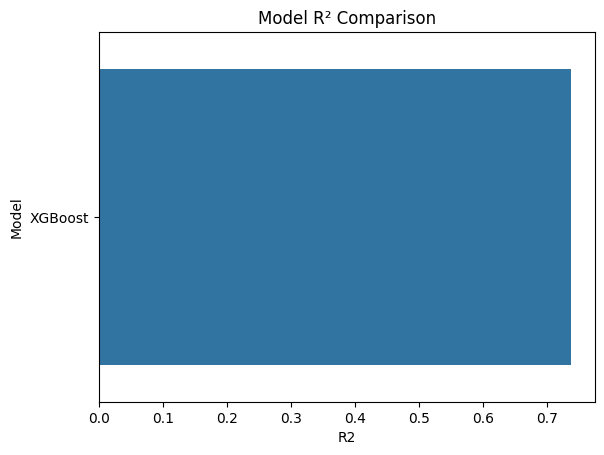

In [52]:
# Sort results and create styled DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
results_df.style.background_gradient(cmap='YlGnBu')

# Define and create save path
save_results = r"models/results/"
os.makedirs(save_results, exist_ok=True)

# Save as CSV
results_df.to_csv(os.path.join(save_results, "model_metrics.csv"), index=False)

print("Model metrics saved to 'model_metrics.csv'")


sns.barplot(x='R2', y='Model', data=results_df)
joblib.dump(preprocessor, os.path.join(save_path, "xgb_preprocessor.pkl"))

plt.title("Model R² Comparison")
plt.show()


Visual Comparison of Model Performance

/tmp/ipykernel_9117/76612517.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_df, palette='viridis')


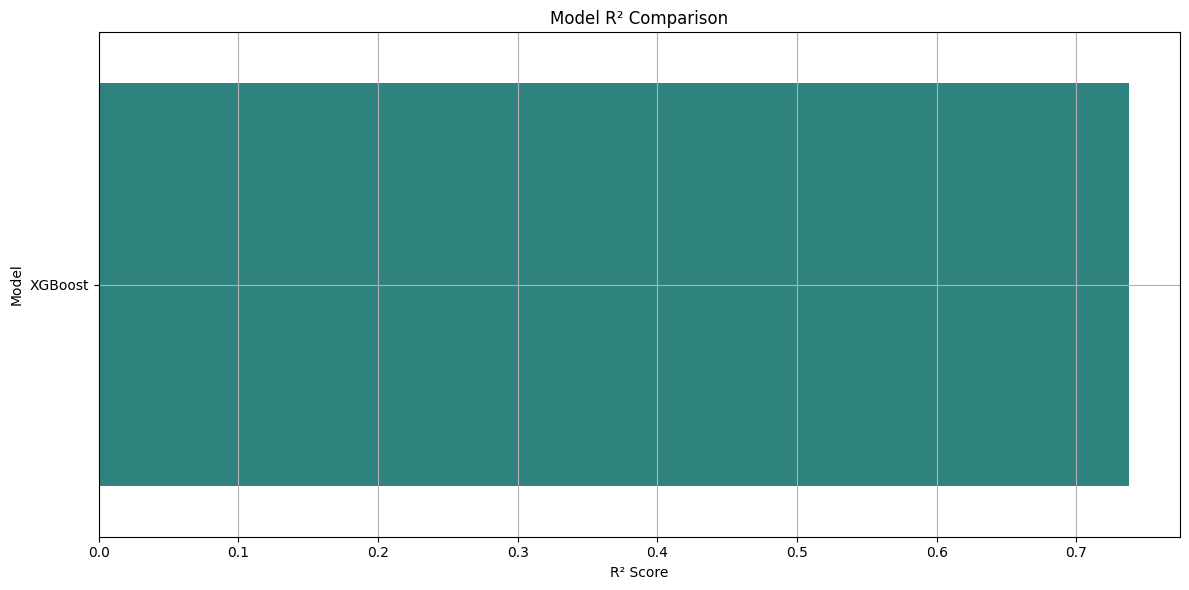

In [53]:
plt.figure(figsize=(12, 6))
sns.barplot(x='R2', y='Model', data=results_df, palette='viridis')
plt.title('Model R² Comparison')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.grid(True)
plt.tight_layout()
plt.show()

Testing Model

In [54]:
sample = x_test.iloc[0:1]
sample_processed = preprocessor.transform(sample)
predicted_level = xgb_model.predict(sample_processed)

actual_level = y_test.iloc[0].item()  # Convert Series to scalar
percentError = abs(predicted_level[0] - actual_level) / abs(actual_level) * 100

print(f"Predicted: {predicted_level[0]:.2f} m")
print(f"Actual   : {actual_level:.2f} m")
print(f"Percent Error: {percentError:.2f}%")


Predicted: 9.13 m
Actual   : 7.02 m
Percent Error: 30.11%


Prediction Error Scale

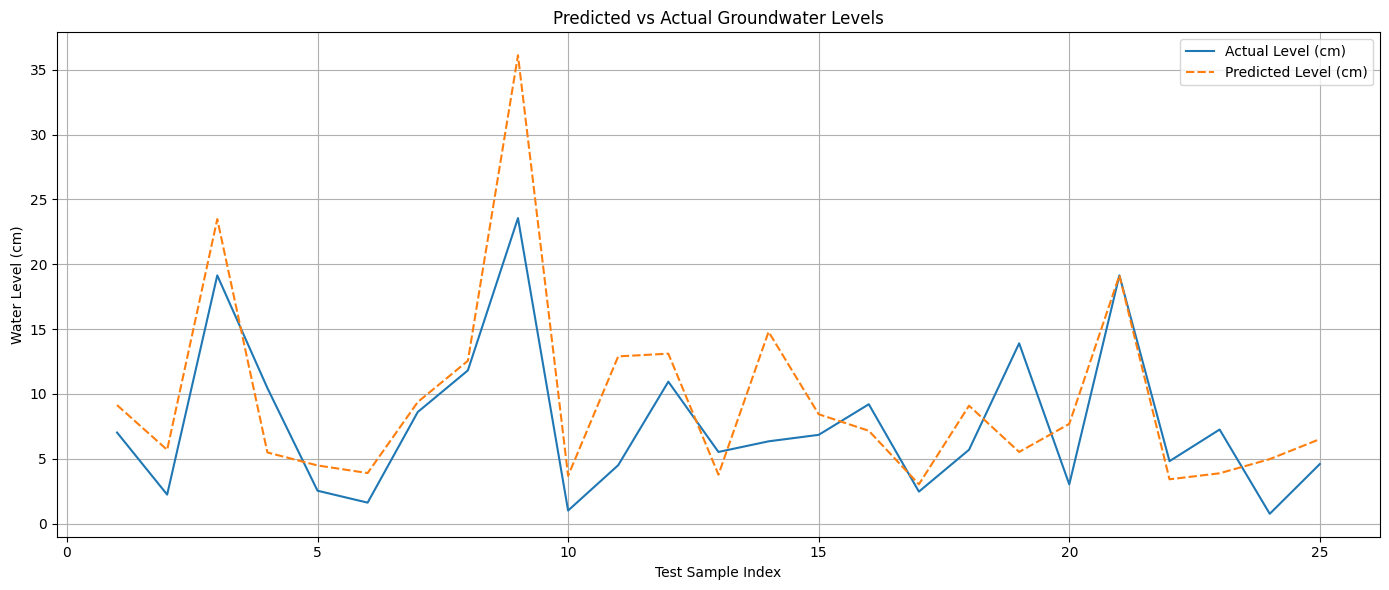

In [55]:
# Choose first N samples to visualize
N = 25
samples = x_test.iloc[:N]
actual_values = y_test.iloc[:N].values.ravel()  # Ensure 1D
predicted_values = xgb_model.predict(preprocessor.transform(samples)).ravel()  # Ensure 1D

# Create DataFrame for plotting
comparison_df = pd.DataFrame({
    'Sample': range(1, N + 1),
    'Actual Level (cm)': actual_values,
    'Predicted Level (cm)': predicted_values
})

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=comparison_df.set_index('Sample'))
plt.title('Predicted vs Actual Groundwater Levels')
plt.ylabel('Water Level (cm)')
plt.xlabel('Test Sample Index')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Model Prediction to CSV

In [ ]:
# # === Load model and preprocessor ===
model_path = r"models/trained_model/xgb_model.pkl"
preprocessor_path = r"models/trained_model/xgb_preprocessor.pkl"

xgb_model = joblib.load(model_path)
preprocessor = joblib.load(preprocessor_path)

#=== Load test data ===
x_test = pd.read_csv("../../dataset/cleanedData/x_test.csv")
y_test = pd.read_csv("../../dataset/cleanedData/y_test.csv").squeeze()

# === Predict ===
x_test_processed = preprocessor.transform(x_test)
predictions = xgb_model.predict(x_test_processed)

# === Save predictions ===
result_df = x_test.copy()
result_df['Actual_Level'] = y_test.values
result_df['Predicted_Level'] = predictions

save_path = r"models/results/predictions.csv"
result_df.to_csv(save_path, index=False)

print("✅ Predictions saved to:", save_path)

✅ Predictions saved to: models/results/predictions.csv
